### DESCRIPTION

Prognostics and health management is an important topic in industry for predicting state of assets to avoid downtime and failures. This data set includes Run-to-Failure simulated data from turbo fan jet engines.

Engine degradation simulation was carried out using C-MAPSS to simulate different combinations of operational conditions and fault modes. Records several sensor channels to characterize fault evolution

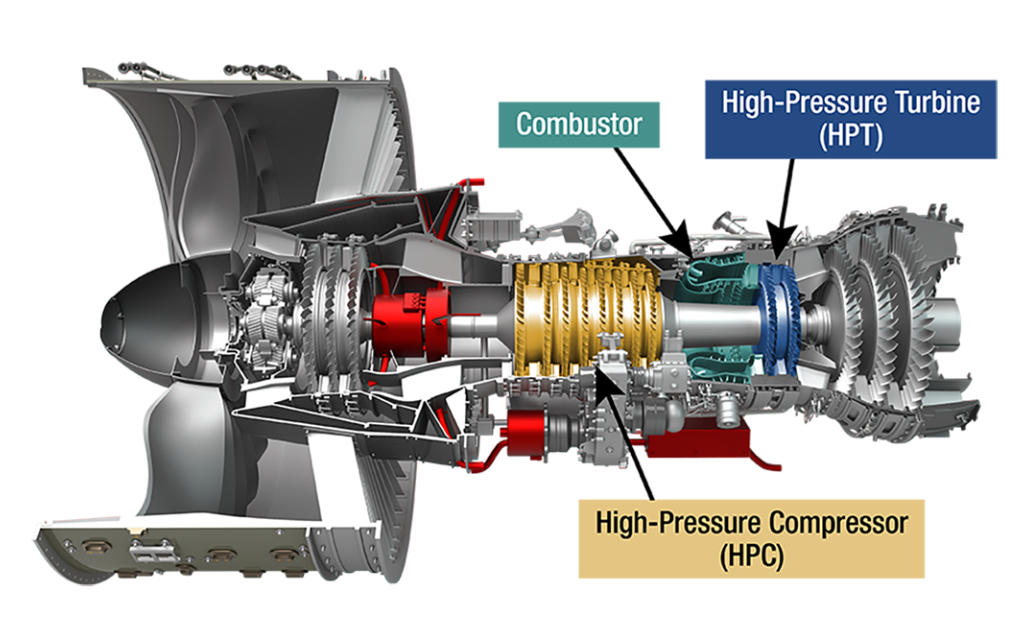

### EXPERIMENTAL SCENARIO

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:
1) unit number<br>
2) time, in cycles<br>
3) operational setting 1<br>
4) operational setting 2<br>
5) operational setting 3<br>
6) sensor measurement 1<br>
7) sensor measurement 2<br>
…<br>
28) sensor measurement 23

### OBJECTIVE

This machine learning project will be directed to provide a framework for predicting the aircraft’s Remaining Useful Life (RUL) based on the entire life cycle data in order to provide the necessary maintenance behavior.

### IMPORT LIBRARIES

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr,f_oneway,chi2_contingency,shapiro,norm,kstest,ttest_ind,spearmanr
import warnings
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import (precision_recall_curve, accuracy_score, confusion_matrix,
                            classification_report, roc_auc_score, roc_curve, auc,plot_confusion_matrix, plot_roc_curve)
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE
from sklearn.impute import KNNImputer
from category_encoders import TargetEncoder
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor
warnings.filterwarnings('ignore')

### IMPORT TRAINING DATASET

In [6]:
df=pd.read_csv(r"\Desktop\train_FD001.txt\train_FD001.txt",sep=' ',header=None)

### IMPORT TESTING DATASET

In [7]:
df_test=pd.read_csv(r"\Desktop\train_FD001.txt\test_FD001.txt",sep=' ',header=None)

In [8]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [9]:
a=['unit_number','time','operation_setting_1','operation_setting_2','operation_setting_3','sensor_measurement_1',
 'sensor_measurement_2',
 'sensor_measurement_3',
 'sensor_measurement_4',
 'sensor_measurement_5',
 'sensor_measurement_6',
 'sensor_measurement_7',
 'sensor_measurement_8',
 'sensor_measurement_9',
 'sensor_measurement_10',
 'sensor_measurement_11',
 'sensor_measurement_12',
 'sensor_measurement_13',
 'sensor_measurement_14',
 'sensor_measurement_15',
 'sensor_measurement_16',
 'sensor_measurement_17',
 'sensor_measurement_18',
 'sensor_measurement_19',
 'sensor_measurement_20',
 'sensor_measurement_21',
 'sensor_measurement_22',
 'sensor_measurement_23']

In [11]:
df.columns=a
df_test.columns=a

### DATA EXPLORATION

In [12]:
#First 5 rows#

df.head()

,unit_number,time,operation_setting_1,operation_setting_2,operation_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,sensor_measurement_22,sensor_measurement_23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [13]:
df.columns

Index(['unit_number', 'time', 'operation_setting_1', 'operation_setting_2',
       'operation_setting_3', 'sensor_measurement_1', 'sensor_measurement_2',
       'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_5',
       'sensor_measurement_6', 'sensor_measurement_7', 'sensor_measurement_8',
       'sensor_measurement_9', 'sensor_measurement_10',
       'sensor_measurement_11', 'sensor_measurement_12',
       'sensor_measurement_13', 'sensor_measurement_14',
       'sensor_measurement_15', 'sensor_measurement_16',
       'sensor_measurement_17', 'sensor_measurement_18',
       'sensor_measurement_19', 'sensor_measurement_20',
       'sensor_measurement_21', 'sensor_measurement_22',
       'sensor_measurement_23'],
      dtype='object')

In [14]:
#Remove unwanted spaces from column names

df.columns=df.columns.str.strip()
df_test.columns=df_test.columns.str.strip()

In [15]:
df.shape

(20631, 28)

* There are around 20500 data points and 28 features in the train dataset

In [16]:
#Info on datatypes of features, count of non null data points

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   unit_number            20631 non-null  int64  
 1   time                   20631 non-null  int64  
 2   operation_setting_1    20631 non-null  float64
 3   operation_setting_2    20631 non-null  float64
 4   operation_setting_3    20631 non-null  float64
 5   sensor_measurement_1   20631 non-null  float64
 6   sensor_measurement_2   20631 non-null  float64
 7   sensor_measurement_3   20631 non-null  float64
 8   sensor_measurement_4   20631 non-null  float64
 9   sensor_measurement_5   20631 non-null  float64
 10  sensor_measurement_6   20631 non-null  float64
 11  sensor_measurement_7   20631 non-null  float64
 12  sensor_measurement_8   20631 non-null  float64
 13  sensor_measurement_9   20631 non-null  float64
 14  sensor_measurement_10  20631 non-null  float64
 15  se

In [17]:
df.describe(include='all')

,unit_number,time,operation_setting_1,operation_setting_2,operation_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21,sensor_measurement_22,sensor_measurement_23
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,0.0,0.0
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,NaN,NaN
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251,NaN,NaN
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,NaN,NaN
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,NaN,NaN
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,NaN,NaN
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,NaN,NaN
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,NaN,NaN


In [18]:
#Count of null values in each column

df.isnull().sum()

unit_number                  0
time                         0
operation_setting_1          0
operation_setting_2          0
operation_setting_3          0
sensor_measurement_1         0
sensor_measurement_2         0
sensor_measurement_3         0
sensor_measurement_4         0
sensor_measurement_5         0
sensor_measurement_6         0
sensor_measurement_7         0
sensor_measurement_8         0
sensor_measurement_9         0
sensor_measurement_10        0
sensor_measurement_11        0
sensor_measurement_12        0
sensor_measurement_13        0
sensor_measurement_14        0
sensor_measurement_15        0
sensor_measurement_16        0
sensor_measurement_17        0
sensor_measurement_18        0
sensor_measurement_19        0
sensor_measurement_20        0
sensor_measurement_21        0
sensor_measurement_22    20631
sensor_measurement_23    20631
dtype: int64

* There are null values present in last 2 columns only
* Last 2 columns are removed from further analysis since all the values are null

In [19]:
df.drop(['sensor_measurement_23','sensor_measurement_22'],axis=1,inplace=True)
df_test.drop(['sensor_measurement_23','sensor_measurement_22'],axis=1,inplace=True)

In [264]:
#Count of unique values in each columns

count_of_unique=[]
columns_=[]
for i in df.columns:
    columns_.append(i)
    count_of_unique.append(df[i].nunique())
pd.DataFrame({'Columns':columns_,'Count of Columns':count_of_unique})

,Columns,Count of Columns
0,unit_number,100
1,time,362
2,operation_setting_1,158
3,operation_setting_2,13
4,sensor_measurement_2,310
5,sensor_measurement_3,3012
6,sensor_measurement_4,4051
7,sensor_measurement_7,513
8,sensor_measurement_8,53
9,sensor_measurement_9,6403


In few columns, there are only 1 or 2 value presents like sensor_measurement_19, sensor_measurement_18, sensor_measurement_16, sensor_measurement_6, sensor_measurement_5 etc...which will not add any value on further analysis and model creation. Therefore these columns are removed

In [21]:
df.drop(['operation_setting_3','sensor_measurement_1','sensor_measurement_19', 
         'sensor_measurement_18', 'sensor_measurement_16', 'sensor_measurement_6', 'sensor_measurement_5',
        'sensor_measurement_10'],axis=1,inplace=True)

df_test.drop(['operation_setting_3','sensor_measurement_1','sensor_measurement_19', 
         'sensor_measurement_18', 'sensor_measurement_16', 'sensor_measurement_6', 'sensor_measurement_5',
        'sensor_measurement_10'],axis=1,inplace=True)

In [22]:
#Count of unique values in each columns#

count_of_unique=[]
columns_=[]
for i in df.columns:
    columns_.append(i)
    count_of_unique.append(df[i].nunique())
pd.DataFrame({'Columns':columns_,'Count of Columns':count_of_unique})

,Columns,Count of Columns
0,unit_number,100
1,time,362
2,operation_setting_1,158
3,operation_setting_2,13
4,sensor_measurement_2,310
5,sensor_measurement_3,3012
6,sensor_measurement_4,4051
7,sensor_measurement_7,513
8,sensor_measurement_8,53
9,sensor_measurement_9,6403


### UNIVARIATE ANALYSIS

In [265]:
# Train dataset

df.describe()

,unit_number,time,operation_setting_1,operation_setting_2,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_17,sensor_measurement_20,sensor_measurement_21
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,642.680934,1590.523119,1408.933782,553.367711,2388.096652,9065.242941,47.541168,521.413470,2388.096152,8143.752722,8.442146,393.210654,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.500053,6.131150,9.000605,0.885092,0.070985,22.082880,0.267087,0.737553,0.071919,19.076176,0.037505,1.548763,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,641.210000,1571.040000,1382.250000,549.850000,2387.900000,9021.730000,46.850000,518.690000,2387.880000,8099.940000,8.324900,388.000000,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,642.325000,1586.260000,1402.360000,552.810000,2388.050000,9053.100000,47.350000,520.960000,2388.040000,8133.245000,8.414900,392.000000,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,642.640000,1590.100000,1408.040000,553.440000,2388.090000,9060.660000,47.510000,521.480000,2388.090000,8140.540000,8.438900,393.000000,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,643.000000,1594.380000,1414.555000,554.010000,2388.140000,9069.420000,47.700000,521.950000,2388.140000,8148.310000,8.465600,394.000000,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,644.530000,1616.910000,1441.490000,556.060000,2388.560000,9244.590000,48.530000,523.380000,2388.560000,8293.720000,8.584800,400.000000,39.430000,23.618400


In [267]:
#Test dataset

df_test.describe()

,unit_number,time,operation_setting_1,operation_setting_2,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_17,sensor_measurement_20,sensor_measurement_21
count,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000,13096.000000
mean,51.543907,76.836515,-0.000011,0.000004,642.475088,1588.099204,1404.735362,553.757523,2388.070964,9058.407363,47.416204,521.747724,2388.071025,8138.947817,8.425844,392.571625,38.892502,23.335743
std,28.289423,53.057749,0.002203,0.000294,0.400899,5.003274,6.688309,0.681286,0.057442,11.436261,0.195917,0.559627,0.056934,10.188605,0.029009,1.233577,0.141681,0.084120
min,1.000000,1.000000,-0.008200,-0.000600,641.130000,1569.040000,1384.390000,550.880000,2387.890000,9024.530000,46.800000,519.380000,2387.890000,8108.500000,8.332800,389.000000,38.310000,22.935400
25%,28.000000,33.000000,-0.001500,-0.000200,642.197500,1584.600000,1399.950000,553.310000,2388.030000,9051.020000,47.270000,521.380000,2388.030000,8132.310000,8.405600,392.000000,38.800000,23.281600
50%,52.000000,69.000000,0.000000,0.000000,642.460000,1587.990000,1404.440000,553.800000,2388.070000,9057.320000,47.410000,521.780000,2388.070000,8138.390000,8.424900,393.000000,38.900000,23.339200
75%,76.000000,113.000000,0.001500,0.000300,642.740000,1591.362500,1409.050000,554.240000,2388.110000,9064.110000,47.540000,522.150000,2388.110000,8144.360000,8.444300,393.000000,38.990000,23.393600
max,100.000000,303.000000,0.007800,0.000700,644.300000,1607.550000,1433.360000,555.840000,2388.300000,9155.030000,48.260000,523.760000,2388.320000,8220.480000,8.541400,397.000000,39.410000,23.641900


* Time cycle in training set has a mean value of 108 while it is 76 in test dataset
* Time cycle in training set has a median value of 104 while it is 69 in test dataset

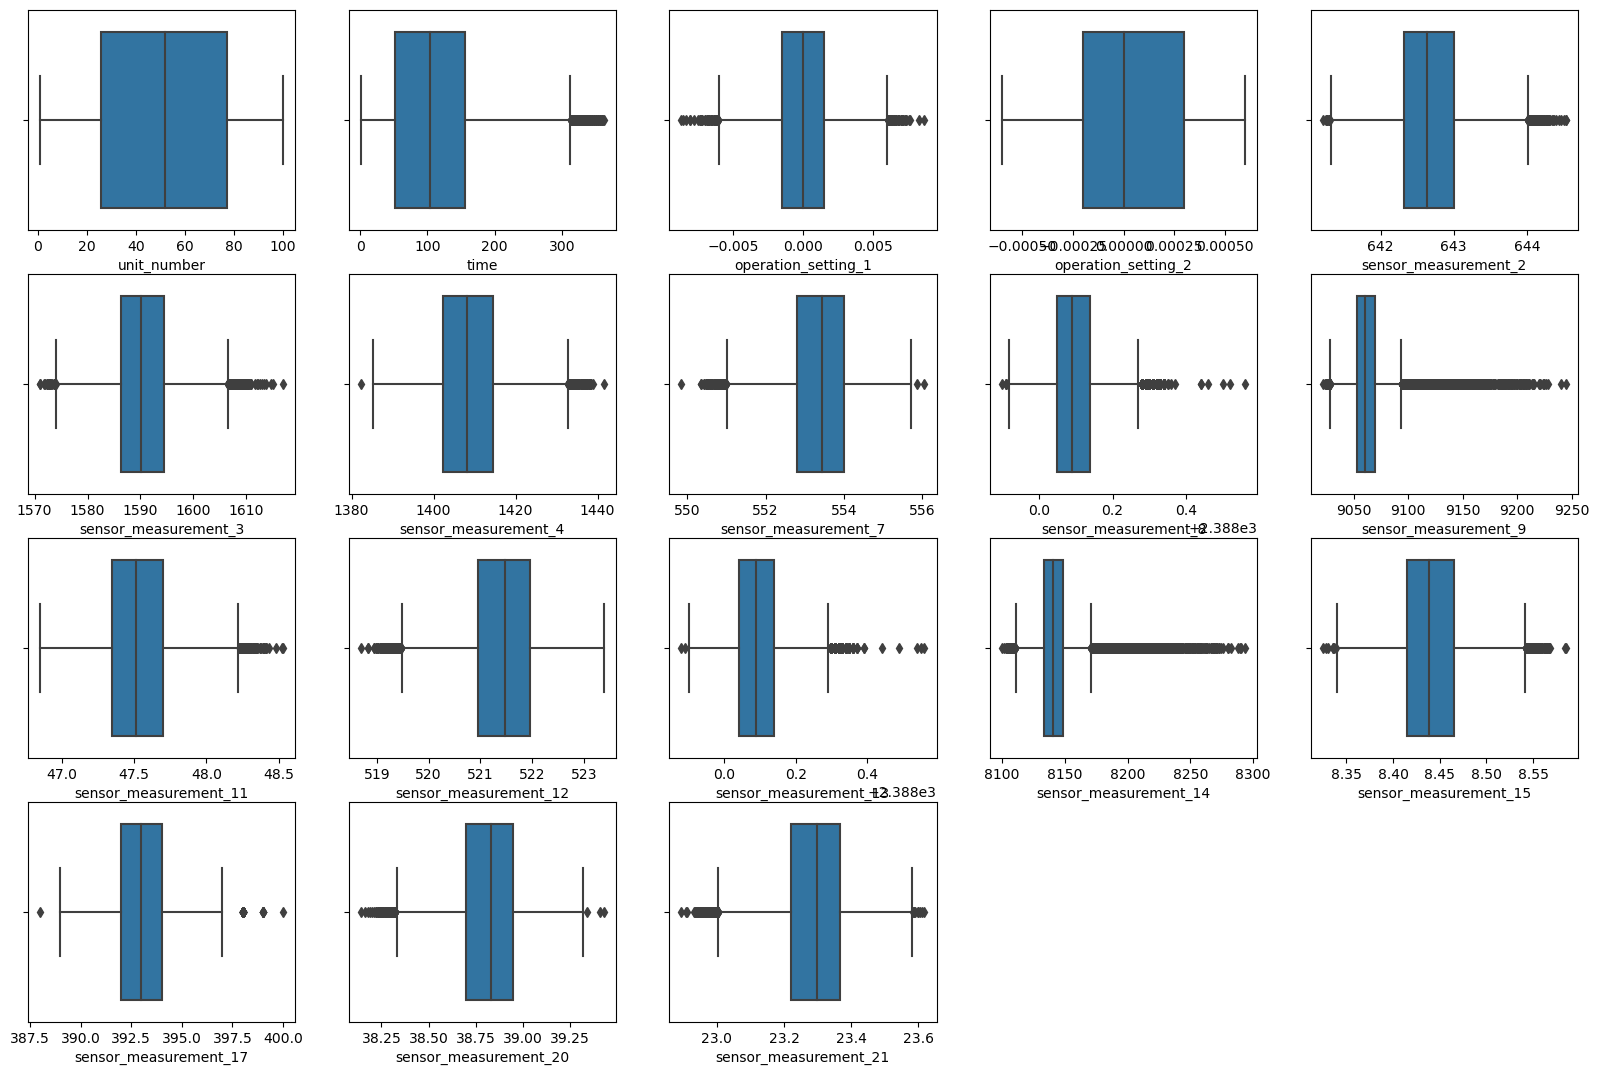

In [269]:
cols_=df.columns 

# Box plots of columns

plt.figure(figsize=(20, 20))

for i in range(1,len(cols_)+1):
    plt.subplot(6, 5, i)
    sns.boxplot(x=cols_[i-1], data=df)


### BIVARIATE ANALYSIS

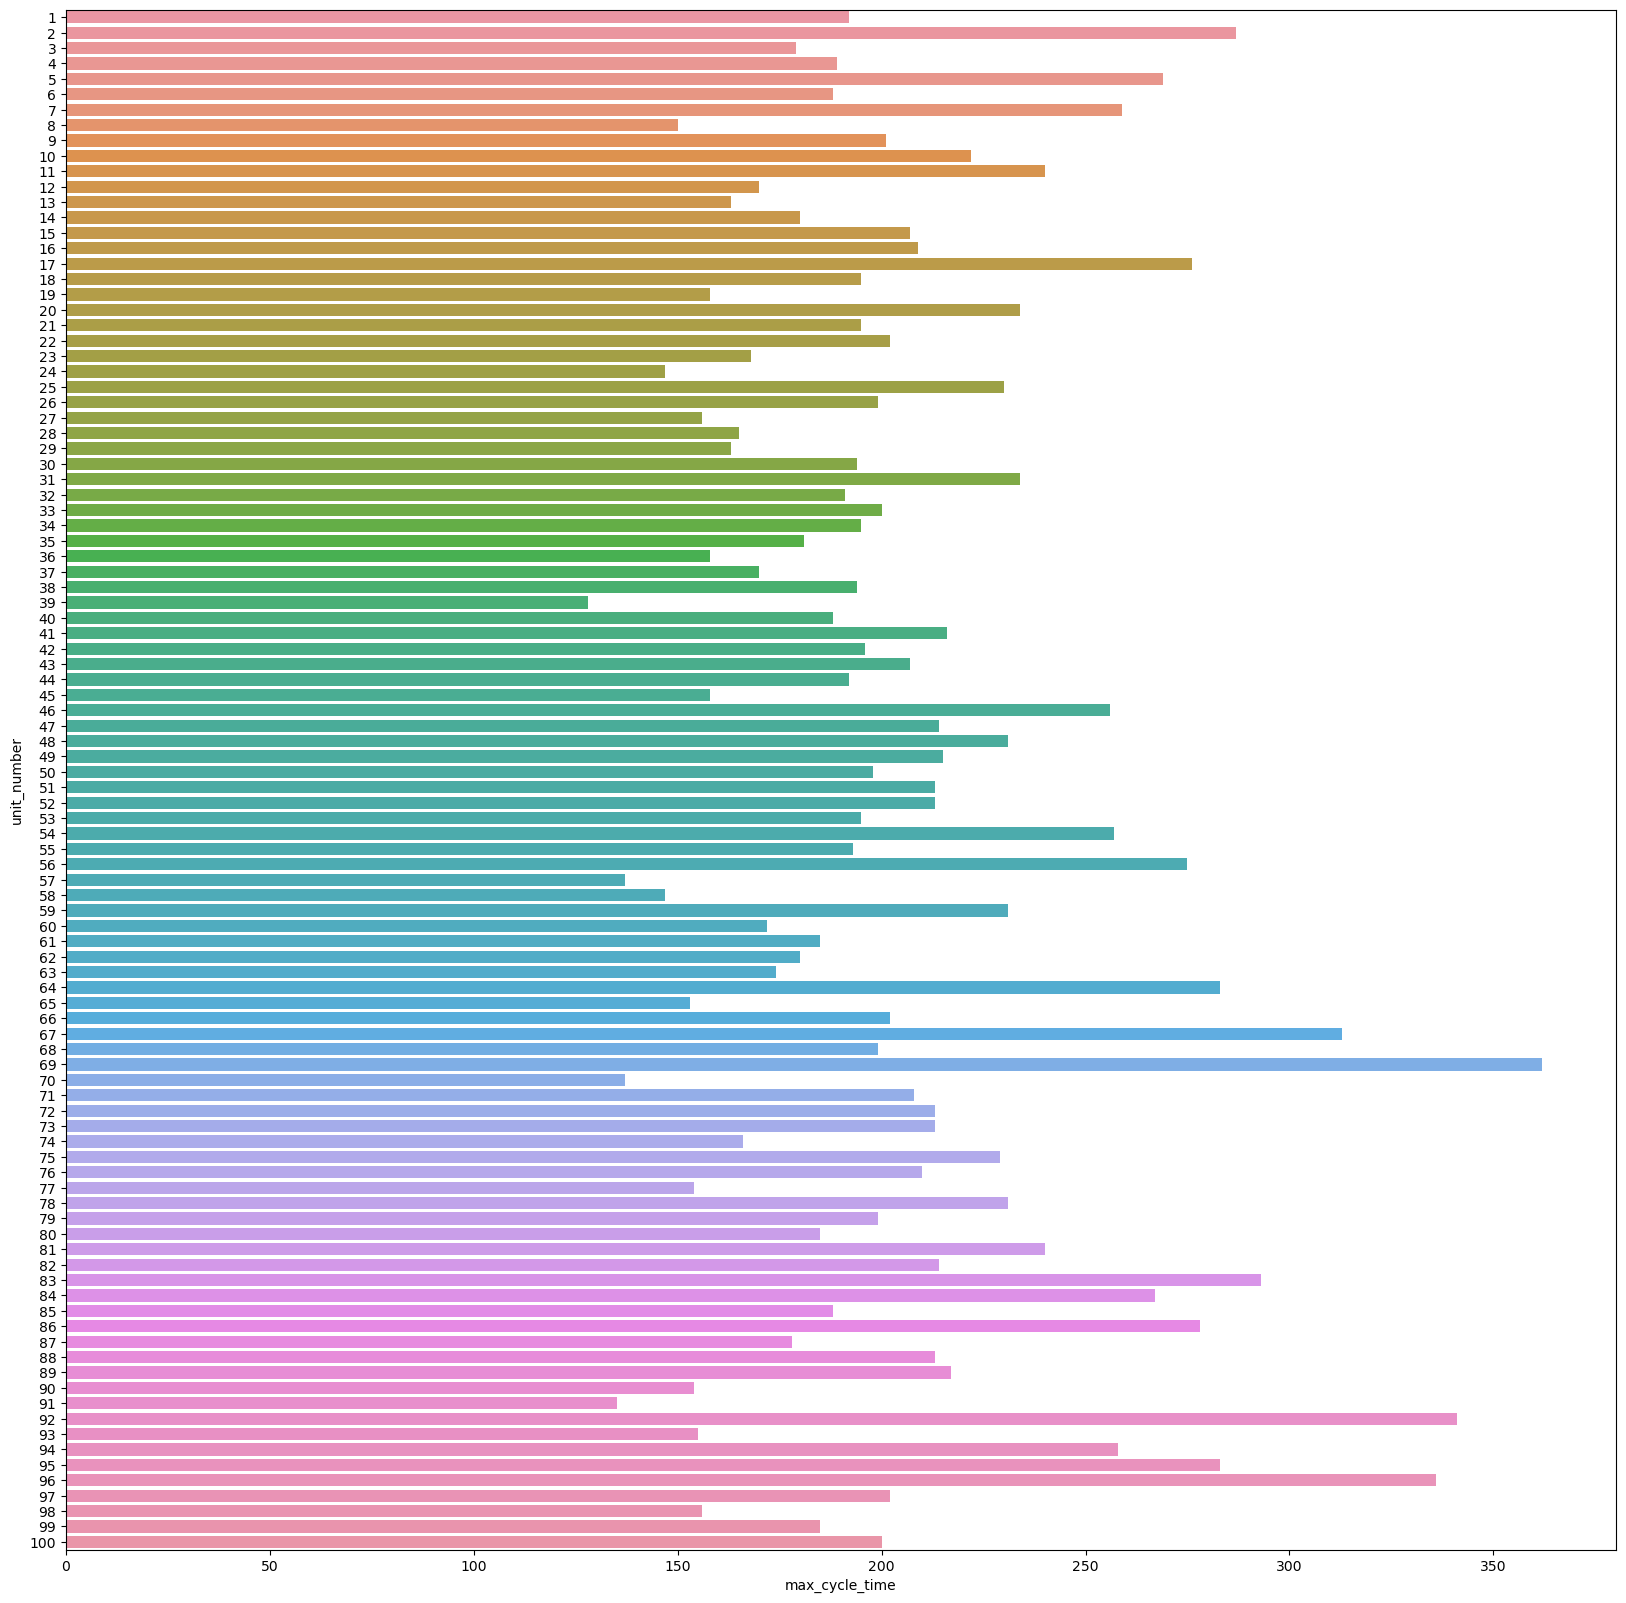

In [24]:
uni_cyc=df.groupby(['unit_number'])['time'].aggregate(max_cycle_time='max').reset_index()
uni_cyc_test=df_test.groupby(['unit_number'])['time'].aggregate(max_cycle_time='max').reset_index()
plt.figure(figsize=(20,20))
sns.barplot(x=uni_cyc['max_cycle_time'],y=uni_cyc['unit_number'],orient='h')
plt.show()

The dataset consists of 100 distinct engine units and each has different cycle times which is based on multiple parameters captured by multiple sensors

### CALCULATE REMAINING USEFUL LIFE (RUL) ( TARGET VARIABLE FOR REGRESSION )

In [25]:
uni_cyc.head()

,unit_number,max_cycle_time
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269


In [26]:
df_merged=df.merge(uni_cyc,on='unit_number',how='left')
df_merged_test=df_test.merge(uni_cyc_test,on='unit_number',how='left')

In [27]:
df_merged['rul'] = df_merged['max_cycle_time'] - df_merged['time']
df_merged_test['rul'] = df_merged_test['max_cycle_time'] - df_merged_test['time']

In [62]:
df_merged.head()

,unit_number,time,operation_setting_1,operation_setting_2,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_17,sensor_measurement_20,sensor_measurement_21,max_cycle_time,rul
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,192,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,192,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,192,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,192,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,192,187


### TARGET VARIABLE FOR CLASSIFICATION

* If machinery needs maintenance, it is represented as **'1'** and if a machinery doesnt need maintenance, it is represented as **'0'**<br>
* A machinery needs maintenance if the cycle time crosses 90% of max cycle time
* Based on above considerations, target variable is created

In [270]:
df_merged['maintenance'] = np.where(df_merged['time']<0.9*df_merged['max_cycle_time'],0,1)
df_merged_test['maintenance'] = np.where(df_merged_test['time']<0.9*df_merged_test['max_cycle_time'],0,1)

In [271]:
df_merged['maintenance'].value_counts()

0    18514
1     2117
Name: maintenance, dtype: int64

### MULTIVARIATE ANALYSIS

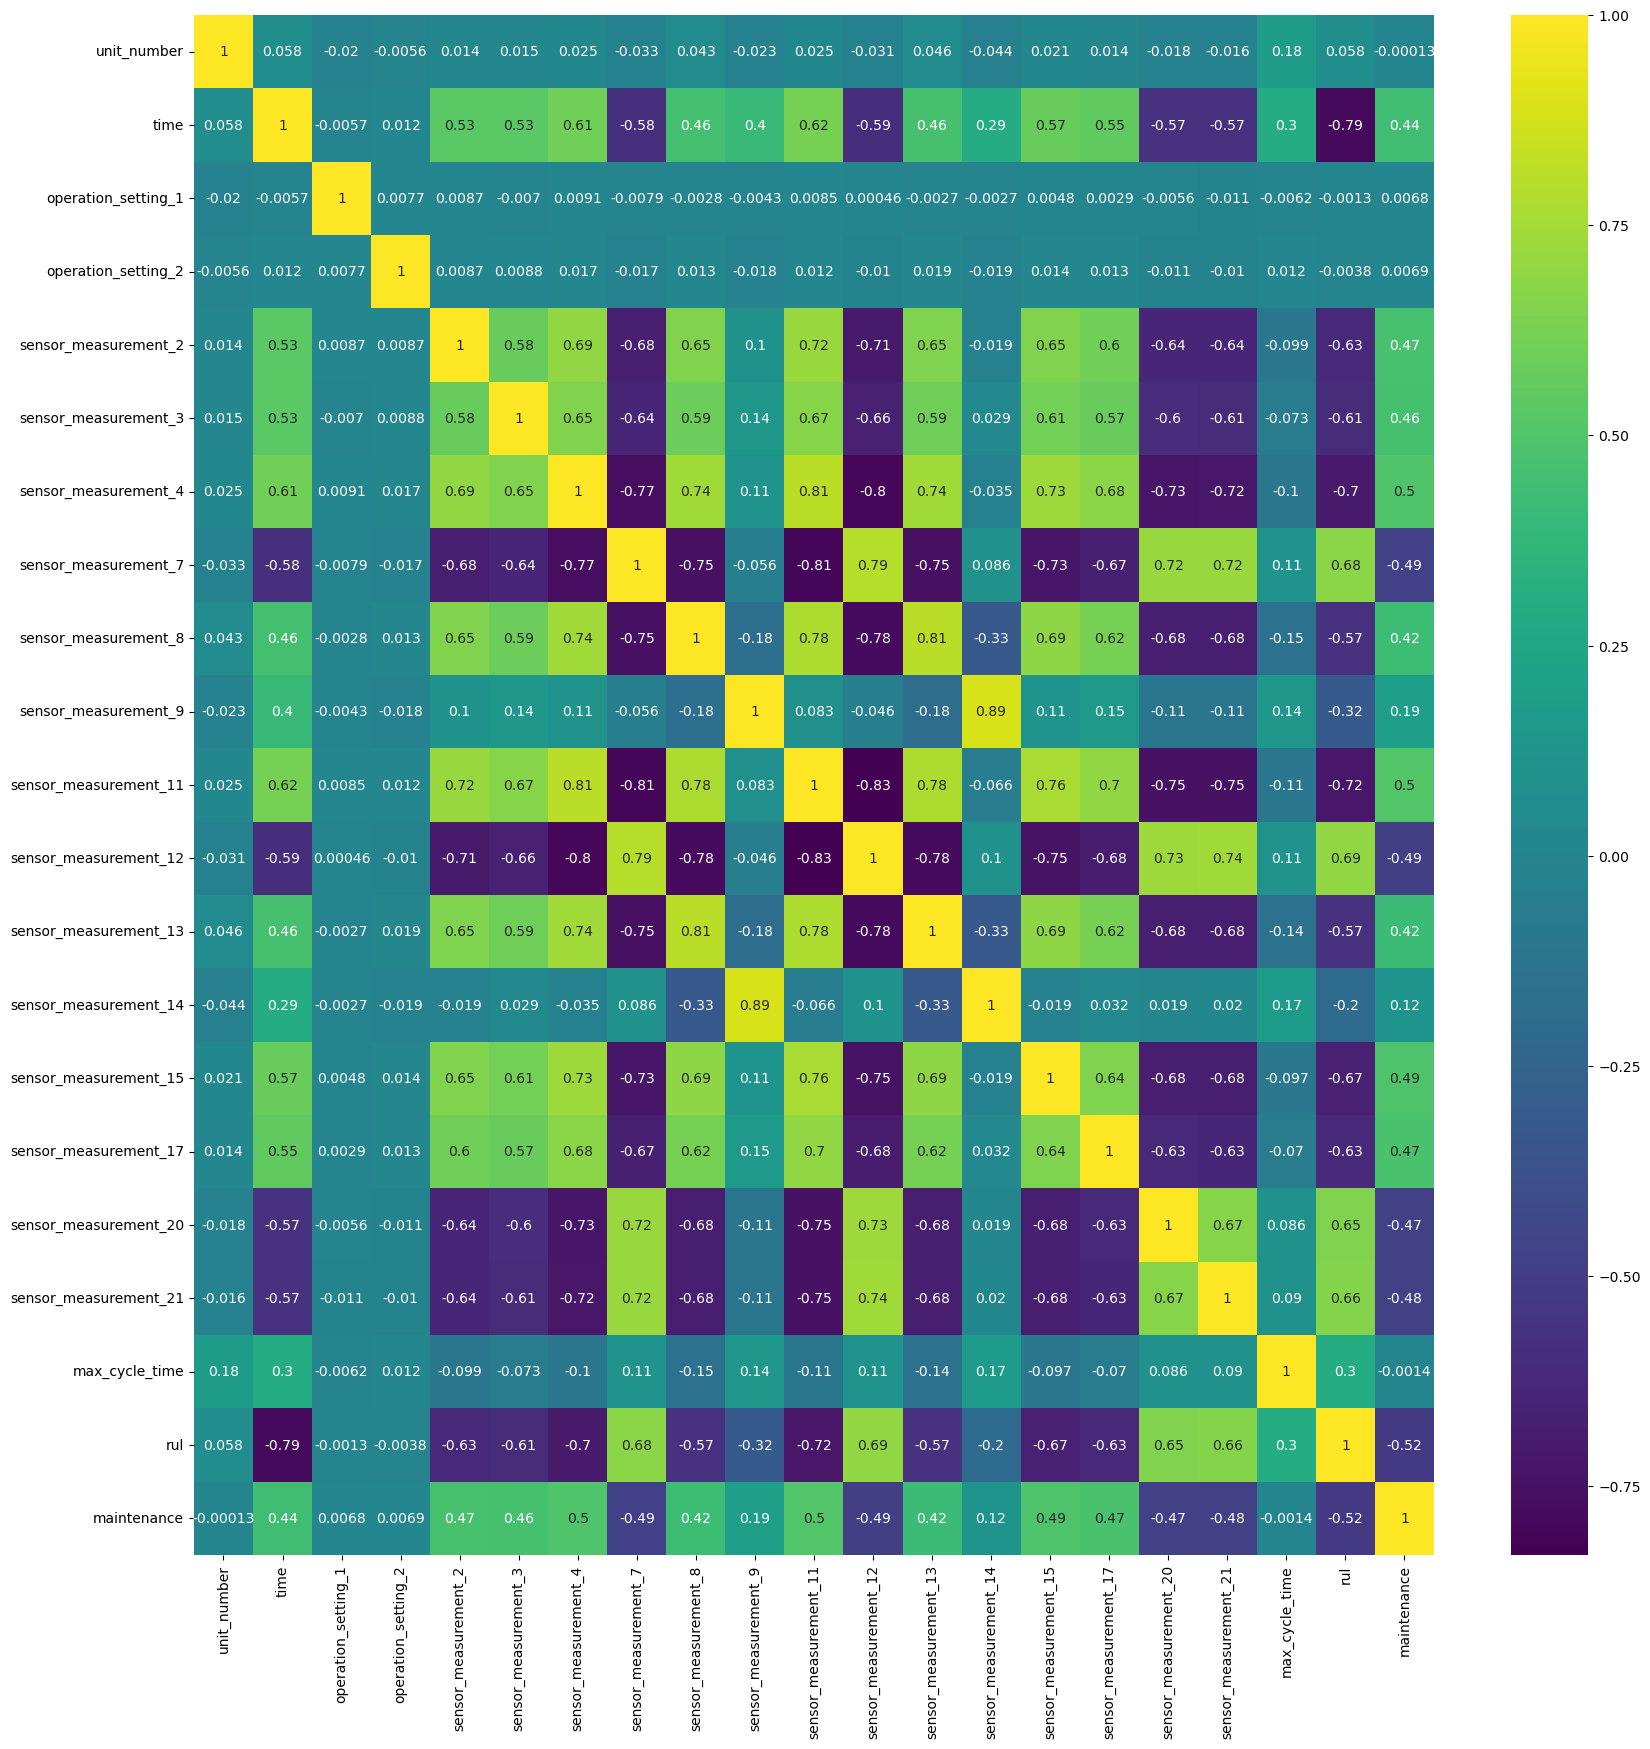

In [272]:
#Correlation heatmap

plt.figure(figsize=(20, 20))
sns.heatmap(df_merged.corr(method='spearman'), annot=True, cmap='viridis')
plt.show()

### HYPOTHESIS TESTING FOR FEATURE EXTRACTION

In [295]:
#Significant features for predicting Remaining Useful Life

cols = df_merged.drop('rul',axis=1).columns

corr_df = pd.DataFrame()
col_list=[]
p=[]
remarks=[]

for i in cols:
    cor_coef,p_val=spearmanr(df_merged[i],df_merged['rul'])
    col_list.append(i)
    p.append(p_val)
    
    if p_val<0.05:
        remarks.append('The feature is significant')
    else:
        remarks.append('The feature is not significant')
    
corr_df['Feature']=col_list
corr_df['P_Value']=p
corr_df['Remarks']=remarks

corr_df

,Feature,P_Value,Remarks
0,unit_number,1.199061e-16,The feature is significant
1,time,0.000000e+00,The feature is significant
2,operation_setting_1,8.483282e-01,The feature is not significant
3,operation_setting_2,5.876239e-01,The feature is not significant
4,sensor_measurement_2,0.000000e+00,The feature is significant
5,sensor_measurement_3,0.000000e+00,The feature is significant
6,sensor_measurement_4,0.000000e+00,The feature is significant
7,sensor_measurement_7,0.000000e+00,The feature is significant
8,sensor_measurement_8,0.000000e+00,The feature is significant
9,sensor_measurement_9,0.000000e+00,The feature is significant


In [296]:
significant_cols=corr_df[corr_df['Remarks']=='The feature is significant']['Feature'].values

df_sig = df_merged[significant_cols]
df_sig_test = df_merged_test[significant_cols]

df_sig.drop(['max_cycle_time','maintenance','unit_number'],axis=1, inplace=True)
df_sig_test.drop(['max_cycle_time','maintenance','unit_number'],axis=1, inplace=True)

* Selected only the features which are significant as per hypothesis testing
* Max cycle time is removed because RUL is derived from this column
* Maintenance column is removed because it is the target variable for classification problem

In [297]:
df_merged['maintenance'].value_counts()

0    18514
1     2117
Name: maintenance, dtype: int64

### DATA PREPARATION FOR MODELLING

In [298]:
X=df_sig.copy()
X1=df_sig_test.copy()
X['rul']=df_merged['rul']
X1['rul']=df_merged_test['rul']
X

,time,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_17,sensor_measurement_20,sensor_measurement_21,rul
0,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,4
20627,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,3
20628,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,2
20629,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,1


In [299]:
scaler = StandardScaler()
X_sc = scaler.fit_transform(X)
X_sc_test = scaler.transform(X1)
X_sc = pd.DataFrame(X_sc,columns=X.columns)
X_sc_test = pd.DataFrame(X_sc_test,columns=X.columns)
y_sc=df_merged['maintenance']
y_sc_test=df_merged_test['maintenance']

### REBALANCE THE IMBALANCED DATA USING SMOTE

In [300]:
y_sc.value_counts()

0    18514
1     2117
Name: maintenance, dtype: int64

In [301]:
smt=SMOTE()
X_sm,y_sm=smt.fit_resample(X_sc,y_sc)
X_sm = pd.DataFrame(X_sm,columns=X.columns)

In [302]:
y_sm.value_counts()

0    18514
1    18514
Name: maintenance, dtype: int64

## PREDICTION USING REGRESSION ALGORITHMS

In [422]:
#Perform inverse_transform to get back the non-scaled data to get the target variable (RUL)

non_scaled_X_sm = scaler.inverse_transform(X_sm)
non_scaled_X_sm = pd.DataFrame(non_scaled_X_sm,columns=X_sm.columns)

non_scaled_X_sc_test = scaler.inverse_transform(X_sc_test)
non_scaled_X_sc_test = pd.DataFrame(non_scaled_X_sc_test,columns=X_sc_test.columns)

In [423]:
X = X_sm.drop('rul',axis=1)
X1 = X_sc_test.drop('rul',axis=1)
y = non_scaled_X_sm['rul']
y1 = non_scaled_X_sc_test['rul']

In [424]:
X_train, X_train_1, y_train, y_train_1 = train_test_split(X, y, test_size=0.01, random_state=42)
X_test, X_test_1, y_test, y_test_1 = train_test_split(X1, y1, test_size=0.01, random_state=42)

### REMOVE FEATURES WITH VIF > 5

In [425]:
deleted_cols=[]
def VIF(X_train):
    vif=pd.DataFrame()
    vif['Features']=X_train.columns
    vif['VIF']=[variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
    vif['VIF']=round(vif['VIF'],2)
    vif=vif.sort_values(by='VIF',ascending=False).reset_index()
    print('**************************************************')
    print(vif)
    print('**************************************************')
    if vif['VIF'][0]>=10:
        deleted_cols.append(vif['Features'][0])
        X_train.drop(vif['Features'][0],inplace=True,axis=1)
        VIF(X_train)
    return (X_train,deleted_cols)
X_train,deleted_cols=VIF(X_train)
X_test.drop(deleted_cols,axis=1,inplace=True)
print("Removed Features : " , len(deleted_cols))

**************************************************
    index               Features    VIF
0       6   sensor_measurement_9  62.02
1      10  sensor_measurement_14  58.20
2       7  sensor_measurement_11  14.48
3       8  sensor_measurement_12  12.16
4       3   sensor_measurement_4  10.85
5       4   sensor_measurement_7   9.79
6       9  sensor_measurement_13   8.93
7       5   sensor_measurement_8   8.79
8      11  sensor_measurement_15   7.40
9      14  sensor_measurement_21   6.73
10     13  sensor_measurement_20   6.45
11      1   sensor_measurement_2   5.42
12     12  sensor_measurement_17   5.27
13      2   sensor_measurement_3   4.63
14      0                   time   3.34
**************************************************
**************************************************
    index               Features    VIF
0       6  sensor_measurement_11  14.44
1       7  sensor_measurement_12  12.15
2       3   sensor_measurement_4  10.81
3       4   sensor_measurement_7   9.78
4      

### LINEAR REGRESSION - BASE MODEL

#### MODEL FITTING

In [426]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

#### CROSS VALIDATION

In [427]:
cv=KFold(n_splits=5)

cross_score=cross_val_score(lr,X_train, y_train,cv=cv, scoring='r2')

print(f'Cross Validation Score : {cross_score}')
print(f'Mean Cross Validation Score : {cross_score.mean()}')

Cross Validation Score : [0.77507697 0.77880698 0.77848456 0.78157057 0.77406175]
Mean Cross Validation Score : 0.7776001649550329


#### MODEL PERFORMANCE ON TRAIN DATA

In [420]:
def adj_square(X,r2):
    n=X.shape[0]
    d=X.shape[1]
    return (1-(((1-r2)*(n-1))/(n-d-1)))

r2 = r2_score(y_train,lr.predict(X_train))
rmse = np.sqrt(mean_squared_error(y_train,lr.predict(X_train)))
adj_r2 = adj_square(X_train,r2)

print(f'R2_SCORE : {r2}')
print(f'ADJUSTED R2_SCORE : {adj_r2}')
print(f'RMSE : {rmse}')

R2_SCORE : 0.7826234099211306
ADJUSTED R2_SCORE : 0.7825344208419247
RMSE : 32.964992994159694


#### MODEL PERFORMANCE ON TEST DATA

In [421]:
r2 = r2_score(y_test,lr.predict(X_test))
rmse = np.sqrt(mean_squared_error(y_test,lr.predict(X_test)))
adj_r2 = adj_square(X_test,r2)

print(f'R2_SCORE : {r2}')
print(f'ADJUSTED R2_SCORE : {adj_r2}')
print(f'RMSE : {rmse}')

R2_SCORE : -0.9595840268314746
ADJUSTED R2_SCORE : -0.9618539905663168
RMSE : 74.14357845342573


* The model is performing poorly on test data while the performance is satisfactory on train data

### RIDGE - BASE MODEL

#### MODEL FITTING

In [312]:
ridge = Ridge()
ridge.fit(X_train, y_train)

Ridge()

#### CROSS VALIDATION

In [313]:
cv=KFold(n_splits=5)

cross_score=cross_val_score(ridge,X_train, y_train,cv=cv, scoring='r2')

print(f'Cross Validation Score : {cross_score}')
print(f'Mean Cross Validation Score : {cross_score.mean()}')

Cross Validation Score : [0.77507689 0.77880713 0.77848455 0.78157101 0.77406139]
Mean Cross Validation Score : 0.7776001933177514


#### HYPER PARAMETER TUNING

In [314]:
poly=PolynomialFeatures()
def polynomial_regression(degree=1):
    return make_pipeline(PolynomialFeatures(degree),Ridge())

model=polynomial_regression()

param={'ridge__alpha':[1,10,60,100],
           'polynomialfeatures__degree':np.arange(2,5)}

scoring='r2'

c = GridSearchCV(model,param,cv=cv,scoring=scoring)
c.fit(X_train,y_train)
def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The score is : {results.best_score_}')
display(c)

Best parameters are : {'polynomialfeatures__degree': 3, 'ridge__alpha': 100}
The score is : 0.8478385389477745


### RIDGE - TUNED MODEL

#### MODEL FITTING

In [315]:
poly=PolynomialFeatures()
def polynomial_regression(degree=2):
    return make_pipeline(PolynomialFeatures(degree=3),Ridge(alpha=100))

ridge=polynomial_regression()
ridge.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('ridge', Ridge(alpha=100))])

#### CROSS VALIDATION

In [316]:
cv=KFold(n_splits=5)

cross_score=cross_val_score(ridge,X_train, y_train,cv=cv, scoring='r2')

print(f'Cross Validation Score : {cross_score}')
print(f'Mean Cross Validation Score : {cross_score.mean()}')

Cross Validation Score : [0.84899869 0.84893609 0.84560246 0.85336937 0.84228609]
Mean Cross Validation Score : 0.8478385389477745


#### MODEL PERFORMANCE ON TRAIN DATA

In [317]:
def adj_square(X,r2):
    n=X.shape[0]
    d=X.shape[1]
    return (1-(((1-r2)*(n-1))/(n-d-1)))

r2 = r2_score(y_train,ridge.predict(X_train))
rmse = np.sqrt(mean_squared_error(y_train,ridge.predict(X_train)))
adj_r2 = adj_square(X_train,r2)

print(f'R2_SCORE : {r2}')
print(f'ADJUSTED R2_SCORE : {adj_r2}')
print(f'RMSE : {rmse}')

R2_SCORE : 0.8510630933767737
ADJUSTED R2_SCORE : 0.8510183858867244
RMSE : 27.286495832438963


#### MODEL PERFORMANCE ON TEST DATA

In [318]:
r2 = r2_score(y_test,ridge.predict(X_test))
rmse = np.sqrt(mean_squared_error(y_test,ridge.predict(X_test)))
adj_r2 = adj_square(X_test,r2)

print(f'R2_SCORE : {r2}')
print(f'ADJUSTED R2_SCORE : {adj_r2}')
print(f'RMSE : {rmse}')

R2_SCORE : -1.1946841712710112
ADJUSTED R2_SCORE : -1.1965479500005705
RMSE : 78.4652952487398


* The model is performing poorly on test data while the performance is satisfactory on train data

### RANDOM FOREST - BASE MODEL

#### MODEL FITTING

In [319]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

#### CROSS VALIDATION

In [320]:
cv=KFold(n_splits=5)

cross_score=cross_val_score(rf,X_train, y_train,cv=cv, scoring='r2')

print(f'Cross Validation Score : {cross_score}')
print(f'Mean Cross Validation Score : {cross_score.mean()}')

Cross Validation Score : [0.8496601  0.85076287 0.84459751 0.85317975 0.84503412]
Mean Cross Validation Score : 0.8486468691626248


#### HYPER PARAMETER TUNING

In [321]:
param = {'max_depth':[5,10], 'n_estimators':[5,10],
        'max_features':['auto','sqrt','log2']}
c = GridSearchCV(rf,param,cv=cv,scoring='r2')
c.fit(X_train,y_train)
def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The score is : {results.best_score_}')
display(c)

Best parameters are : {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 10}
The score is : 0.8456898655178225


### RANDOM FOREST - TUNED MODEL

#### MODEL FITTING

In [322]:
rf = RandomForestRegressor(n_estimators=10, max_depth=10, max_features='sqrt')
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=10)

#### CROSS VALIDATION

In [323]:
cv=KFold(n_splits=5)

cross_score=cross_val_score(rf,X_train, y_train,cv=cv, scoring='r2')

print(f'Cross Validation Score : {cross_score}')
print(f'Mean Cross Validation Score : {cross_score.mean()}')

Cross Validation Score : [0.84760048 0.84723419 0.84476929 0.85123363 0.83899387]
Mean Cross Validation Score : 0.8459662928218462


#### MODEL PERFORMANCE ON TRAIN DATA

In [324]:
def adj_square(X,r2):
    n=X.shape[0]
    d=X.shape[1]
    return (1-(((1-r2)*(n-1))/(n-d-1)))

r2 = r2_score(y_train,rf.predict(X_train))
rmse = np.sqrt(mean_squared_error(y_train,rf.predict(X_train)))
adj_r2 = adj_square(X_train,r2)

print(f'R2_SCORE : {r2}')
print(f'ADJUSTED R2_SCORE : {adj_r2}')
print(f'RMSE : {rmse}')

R2_SCORE : 0.8791252291986563
ADJUSTED R2_SCORE : 0.8790889453269463
RMSE : 24.58184260868898


#### MODEL PERFORMANCE ON TEST DATA

In [325]:
r2 = r2_score(y_test,rf.predict(X_test))
rmse = np.sqrt(mean_squared_error(y_test,rf.predict(X_test)))
adj_r2 = adj_square(X_test,r2)

print(f'R2_SCORE : {r2}')
print(f'ADJUSTED R2_SCORE : {adj_r2}')
print(f'RMSE : {rmse}')

R2_SCORE : -1.1311607832748938
ADJUSTED R2_SCORE : -1.132970616411312
RMSE : 77.32139939671768


* The model is performing poorly on test data while the performance is satisfactory on train data

### XGBOOST - BASE MODEL

#### MODEL FITTING

In [428]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

#### CROSS VALIDATION

In [429]:
cv=KFold(n_splits=5)

cross_score=cross_val_score(xgb,X_train, y_train,cv=cv, scoring='r2')

print(f'Cross Validation Score : {cross_score}')
print(f'Mean Cross Validation Score : {cross_score.mean()}')

Cross Validation Score : [0.84133104 0.84323469 0.83277011 0.84437329 0.83228189]
Mean Cross Validation Score : 0.838798202247693


#### HYPER PARAMETER TUNING

In [438]:
param = {'max_depth':[5,10], 'n_estimators':[5,10],
        'max_features':['auto','sqrt','log2'],'learning_rate':[0.01,1,2]}
c = GridSearchCV(xgb,param,cv=cv,scoring='r2')
c.fit(X_train,y_train)
def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The score is : {results.best_score_}')
display(c)

Best parameters are : {'learning_rate': 1, 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 5}
The score is : 0.8343644825281817


### XGBOOST - TUNED MODEL

#### MODEL FITTING

In [440]:
xgb = XGBRegressor(n_estimators=5,max_depth=5, max_features='auto',learning_rate=1)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_features='auto',
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=5,
             n_jobs=None, num_parallel_tree=None, ...)

#### CROSS VALIDATION

In [441]:
cv=KFold(n_splits=5)

cross_score=cross_val_score(xgb,X_train, y_train,cv=cv, scoring='r2')

print(f'Cross Validation Score : {cross_score}')
print(f'Mean Cross Validation Score : {cross_score.mean()}')

Cross Validation Score : [0.83497006 0.83582315 0.83129235 0.84181705 0.82791979]
Mean Cross Validation Score : 0.8343644825281817


#### MODEL PERFORMANCE ON TRAIN DATA

In [442]:
def adj_square(X,r2):
    n=X.shape[0]
    d=X.shape[1]
    return (1-(((1-r2)*(n-1))/(n-d-1)))

r2 = r2_score(y_train,xgb.predict(X_train))
rmse = np.sqrt(mean_squared_error(y_train,xgb.predict(X_train)))
adj_r2 = adj_square(X_train,r2)

print(f'R2_SCORE : {r2}')
print(f'ADJUSTED R2_SCORE : {adj_r2}')
print(f'RMSE : {rmse}')

R2_SCORE : 0.8511205760439104
ADJUSTED R2_SCORE : 0.8510758858088574
RMSE : 27.281229669860554


#### MODEL PERFORMANCE ON TEST DATA

In [443]:
r2 = r2_score(y_test,xgb.predict(X_test))
rmse = np.sqrt(mean_squared_error(y_test,xgb.predict(X_test)))
adj_r2 = adj_square(X_test,r2)

print(f'R2_SCORE : {r2}')
print(f'ADJUSTED R2_SCORE : {adj_r2}')
print(f'RMSE : {rmse}')

R2_SCORE : -1.2432472804722101
ADJUSTED R2_SCORE : -1.2451523001653464
RMSE : 79.32866989242214


### SUMMARIZE THE REGRESSION MODEL METRICS

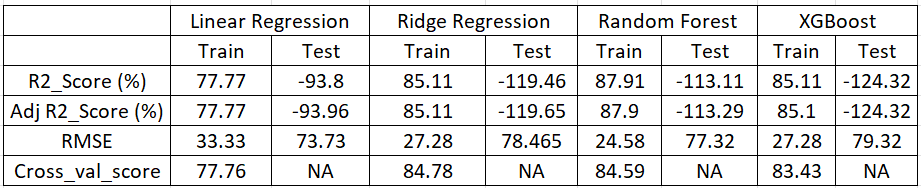

* Every model is performing poorly on test data while the performance is really good on train data
* Ridge Regression, Random Forest & XGBoost are the best models in terms of model metrics on train dataset
* Ridge Regression can be considered as the final model since it is much simpler and better in interpretation
* Drill down analysis of why models performed poorly on test data will be done at the end after checking classification approach

### FINALIZE THRESHOLD FOR RUL

<AxesSubplot:ylabel='Count'>

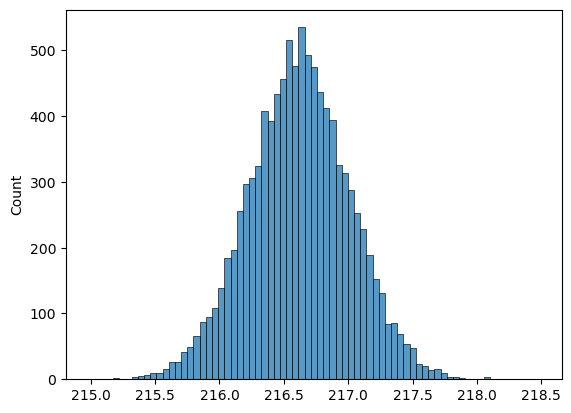

In [344]:
#Bootstrapping to get a normal distribution to get the confidence interval

cycle_dist=[]
for i in range(10000):
    cycle_dist.append(np.mean(np.random.choice(df_merged['max_cycle_time'],size=16000)))
    
sns.histplot(cycle_dist)

In [345]:
#Determine 95% Confidence Interval

min_confid = np.percentile(cycle_dist,2.5)
max_confid = np.percentile(cycle_dist,97.5)

print(f'95% Confidence Interval is {np.round(min_confid,2)} - {np.round(max_confid,2)}')

95% Confidence Interval is 215.84 - 217.39


* Threshold is finalised based on the consideration that when the number of cycles crosses 90% of the maximum cycle time, maintenance should be done.<br>
* Understanding that 95% confidence interval is 215.85 - 217.39, the threshold should be 194<br>
* Maintenance to be initiated when the cycle time crosses **194**

## PREDICTION USING CLASSIFICATION ALGORITHMS

In [467]:
X = X_sm.drop(['rul'],axis=1)
X1 = X_sc_test.drop('rul',axis=1)
y = y_sm.copy()
y1 = y_sc_test.copy()

In [468]:
X_train, X_train_1, y_train, y_train_1 = train_test_split(X, y, test_size=0.01, random_state=42)
X_test, X_test_1, y_test, y_test_1 = train_test_split(X1, y1, test_size=0.2, random_state=42)

### LOGISTIC REGRESSION - BASE MODEL

#### MODEL FITTING

In [456]:
log = LogisticRegression()
log.fit(X_train, y_train)

LogisticRegression()

#### CROSS VALIDATION

In [457]:
cv=KFold(n_splits=5)

cross_score=cross_val_score(log,X_train, y_train,cv=cv, scoring='recall')

print(f'Cross Validation Score : {cross_score}')
print(f'Mean Cross Validation Score : {cross_score.mean()}')

Cross Validation Score : [0.98326934 0.98138516 0.98011983 0.98027027 0.97805815]
Mean Cross Validation Score : 0.9806205482060799


#### HYPER PARAMETER TUNING

In [350]:
param = {'C':[50,30,40],'penalty':['l2','l1'],'max_iter':[50,60,70]}
c = GridSearchCV(log,param,cv=cv,scoring='f1')
c.fit(X_train,y_train)
def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The score is : {results.best_score_}')
display(c)

Best parameters are : {'C': 50, 'max_iter': 50, 'penalty': 'l2'}
The score is : 0.9713854136840654


### LOGISTIC REGRESSION - TUNED MODEL

#### MODEL FITTING

In [469]:
log = LogisticRegression(penalty='l2',C=50,max_iter=50)
log.fit(X_train, y_train)

LogisticRegression(C=50, max_iter=50)

#### CROSS VALIDATION

In [470]:
cv=KFold(n_splits=5)

cross_score=cross_val_score(log,X_train, y_train,cv=cv, scoring='f1')

print(f'Cross Validation Score : {cross_score}')
print(f'Mean Cross Validation Score : {cross_score.mean()}')

Cross Validation Score : [0.96956581 0.97311244 0.97230852 0.97264682 0.96929348]
Mean Cross Validation Score : 0.9713854136840654


#### MODEL PERFORMANCE ON TRAIN DATA

In [353]:
confusion_matrix(y_train, log.predict(X_train))

array([[17638,   702],
       [  350, 17967]], dtype=int64)

In [354]:
print(classification_report(y_train, log.predict(X_train)))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     18340
           1       0.96      0.98      0.97     18317

    accuracy                           0.97     36657
   macro avg       0.97      0.97      0.97     36657
weighted avg       0.97      0.97      0.97     36657



In [357]:
roc_auc_score(y_train, log.predict(X_train))

0.9713075386464559

#### MODEL PERFORMANCE ON TEST DATA

In [355]:
confusion_matrix(y_test, log.predict(X_test))

array([[9356,   14],
       [ 951,  155]], dtype=int64)

In [356]:
print(classification_report(y_test, log.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      9370
           1       0.92      0.14      0.24      1106

    accuracy                           0.91     10476
   macro avg       0.91      0.57      0.60     10476
weighted avg       0.91      0.91      0.88     10476



In [358]:
roc_auc_score(y_test, log.predict(X_test))

0.5693252676291732

* The model is performing poorly on test data while the performance is satisfactory on train data

### RANDOM FOREST CLASSIFIER - BASE MODEL

#### MODEL FITTING

In [359]:
rfcl = RandomForestClassifier()
rfcl.fit(X_train, y_train)

RandomForestClassifier()

#### CROSS VALIDATION

In [360]:
cv=KFold(n_splits=5)

cross_score=cross_val_score(rfcl,X_train, y_train,cv=cv, scoring='f1')

print(f'Cross Validation Score : {cross_score}')
print(f'Mean Cross Validation Score : {cross_score.mean()}')

Cross Validation Score : [0.98415278 0.98928814 0.98812416 0.98517034 0.98659082]
Mean Cross Validation Score : 0.9866652465964656


#### HYPER PARAMETER TUNING

In [361]:
param = {'max_depth':[5,10], 'n_estimators':[5,10], 'criterion':['gini','entropy'],
        'max_features':['auto','sqrt','log2']}
c = GridSearchCV(rfcl,param,cv=cv,scoring='recall')
c.fit(X_train,y_train)
def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The score is : {results.best_score_}')
display(c)

Best parameters are : {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 10}
The score is : 0.9959620053968523


### RANDOM FOREST CLASSIFIER - TUNED MODEL

#### MODEL FITTING

In [362]:
rfcl = RandomForestClassifier(criterion='gini',max_depth=10, max_features ='log2',n_estimators= 10)
rfcl.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, max_features='log2', n_estimators=10)

#### CROSS VALIDATION

In [363]:
cross_score=cross_val_score(rfcl,X_train, y_train,cv=cv, scoring='f1')

print(f'Cross Validation Score : {cross_score}')
print(f'Mean Cross Validation Score : {cross_score.mean()}')

Cross Validation Score : [0.97789757 0.98392978 0.98360656 0.98160981 0.97959735]
Mean Cross Validation Score : 0.9813282136980389


#### MODEL PERFORMANCE ON TRAIN DATA

In [364]:
confusion_matrix(y_train, rfcl.predict(X_train))

array([[17920,   420],
       [   11, 18306]], dtype=int64)

In [365]:
print(classification_report(y_train, rfcl.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     18340
           1       0.98      1.00      0.99     18317

    accuracy                           0.99     36657
   macro avg       0.99      0.99      0.99     36657
weighted avg       0.99      0.99      0.99     36657



In [366]:
roc_auc_score(y_train, rfcl.predict(X_train))

0.9882493508095553

#### MODEL PERFORMANCE ON TEST DATA

In [367]:
confusion_matrix(y_test, rfcl.predict(X_test))

array([[9361,    9],
       [ 957,  149]], dtype=int64)

In [368]:
print(classification_report(y_test, rfcl.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      9370
           1       0.94      0.13      0.24      1106

    accuracy                           0.91     10476
   macro avg       0.93      0.57      0.59     10476
weighted avg       0.91      0.91      0.88     10476



In [369]:
roc_auc_score(y_test, rfcl.predict(X_test))

0.5668795991979327

* The model is performing poorly on test data while the performance is satisfactory on train data

### XGBOOST CLASSIFIER - BASE MODEL

#### MODEL FITTING

In [370]:
xgbcl = XGBClassifier()
xgbcl.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

#### CROSS VALIDATION

In [371]:
cv=KFold(n_splits=5)

cross_score=cross_val_score(xgbcl,X_train, y_train,cv=cv, scoring='f1')

print(f'Cross Validation Score : {cross_score}')
print(f'Mean Cross Validation Score : {cross_score.mean()}')

Cross Validation Score : [0.98722826 0.99116247 0.98971026 0.986731   0.98939064]
Mean Cross Validation Score : 0.9888445282488474


#### HYPER PARAMETER TUNING

In [398]:
param = {'max_depth':[10,20], 'n_estimators':[10,20], 'criterion':['gini','entropy'],
        'max_features':['auto','sqrt','log2'], 'learning_rate':[0.001,0.01,1]}
c = GridSearchCV(xgbcl,param,cv=cv,scoring='f1')
c.fit(X_train,y_train)
def display(results):
    print(f'Best parameters are : {results.best_params_}')
    print(f'The score is : {results.best_score_}')
display(c)

Best parameters are : {'criterion': 'gini', 'learning_rate': 1, 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 20}
The score is : 0.9876322954454173


### RANDOM FOREST CLASSIFIER - TUNED MODEL

#### MODEL FITTING

In [403]:
xgbcl = XGBClassifier(learning_rate=0.001 ,criterion='gini',max_depth=10, max_features ='auto',n_estimators= 20)
xgbcl.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, criterion='gini', device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_features='auto',
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=20,
              n_jobs=None, ...)

#### CROSS VALIDATION

In [404]:
cross_score=cross_val_score(xgbcl,X_train, y_train,cv=cv, scoring='f1')

print(f'Cross Validation Score : {cross_score}')
print(f'Mean Cross Validation Score : {cross_score.mean()}')

Cross Validation Score : [0.97165227 0.97759179 0.98019135 0.97472924 0.97340354]
Mean Cross Validation Score : 0.9755136376843557


#### MODEL PERFORMANCE ON TRAIN DATA

In [405]:
confusion_matrix(y_train, xgbcl.predict(X_train))

array([[17845,   495],
       [  103, 18214]], dtype=int64)

In [406]:
print(classification_report(y_train, xgbcl.predict(X_train)))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98     18340
           1       0.97      0.99      0.98     18317

    accuracy                           0.98     36657
   macro avg       0.98      0.98      0.98     36657
weighted avg       0.98      0.98      0.98     36657



In [407]:
roc_auc_score(y_train, xgbcl.predict(X_train))

0.983693311521098

#### MODEL PERFORMANCE ON TEST DATA

In [408]:
confusion_matrix(y_test, xgbcl.predict(X_test))

array([[9352,   18],
       [ 947,  159]], dtype=int64)

In [409]:
print(classification_report(y_test, xgbcl.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      9370
           1       0.90      0.14      0.25      1106

    accuracy                           0.91     10476
   macro avg       0.90      0.57      0.60     10476
weighted avg       0.91      0.91      0.88     10476



In [410]:
roc_auc_score(y_test, xgbcl.predict(X_test))

0.5709201387213627

### SUMMARIZE THE CLASSIFICATION MODEL METRICS

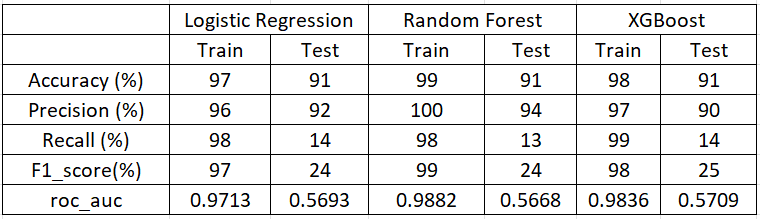

* Every model is performing poorly on test data while the performance is really good on train data
* All models are performing equally well on train dataset
* Logistic Regression can be considered as the final model since it is much simpler and better in interpretation

### FEATURE IMPORTANCES

In [473]:
fi = pd.DataFrame()
fi['Features']=X_train.columns
fi['Coefficients']=log.coef_[0]
fi.sort_values(by='Coefficients',ascending=False)

,Features,Coefficients
7,sensor_measurement_11,1.600510
6,sensor_measurement_9,1.474921
9,sensor_measurement_13,1.232610
5,sensor_measurement_8,1.170298
0,time,0.916116
3,sensor_measurement_4,0.698889
11,sensor_measurement_15,0.433020
10,sensor_measurement_14,0.334578
1,sensor_measurement_2,0.300632
12,sensor_measurement_17,0.203128


* Sensor measurements 11, 9, 13 & 8 is having the highest contribution in prediction of RUL

### DRILL DOWN ANALYSIS OF POOR PERFORMANCE OF MODELS ON TEST DATASET

#### Bootstrapping of max_cycle_time feature from train dataset to estimate confidence interval

<AxesSubplot:ylabel='Count'>

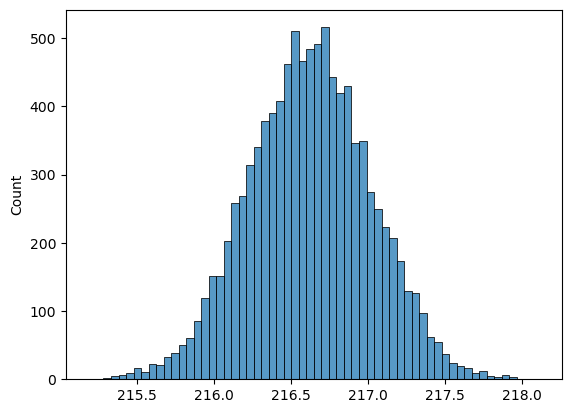

In [257]:
#Bootstrapping to get a normal distribution to get the confidence interval

cycle_dist=[]
for i in range(10000):
    cycle_dist.append(np.mean(np.random.choice(df_merged['max_cycle_time'],size=16000)))
    
sns.histplot(cycle_dist)

In [260]:
#Determine 95% Confidence Interval

min_confid = np.percentile(cycle_dist,2.5)
max_confid = np.percentile(cycle_dist,97.5)

print(f'95% Confidence Interval is {np.round(min_confid,2)} - {np.round(max_confid,2)}')

95% Confidence Interval is 215.85 - 217.38


#### Bootstrapping of max_cycle_time feature from test dataset to estimate confidence interval

<AxesSubplot:ylabel='Count'>

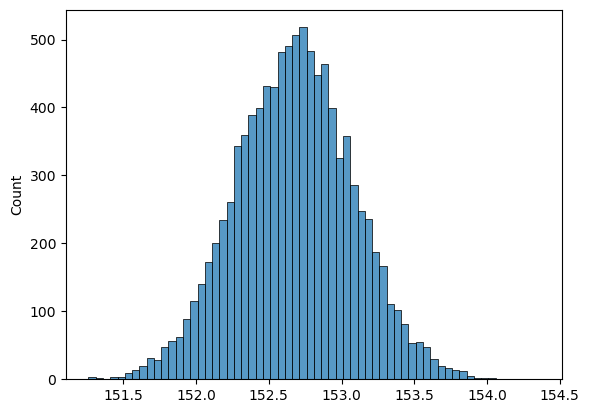

In [261]:
#Bootstrapping to get a normal distribution to get the confidence interval

cycle_dist=[]
for i in range(10000):
    cycle_dist.append(np.mean(np.random.choice(df_merged_test['max_cycle_time'],size=16000)))
    
sns.histplot(cycle_dist)

In [262]:
#Determine 95% Confidence Interval

min_confid = np.percentile(cycle_dist,2.5)
max_confid = np.percentile(cycle_dist,97.5)

print(f'95% Confidence Interval is {np.round(min_confid,2)} - {np.round(max_confid,2)}')

95% Confidence Interval is 151.89 - 153.47


* Normal distribution is seen in both the cases ( train & test )
* Confidence interval : <br>
    * Train dataset : 215.85 - 217.38
    * Test dataset  : 151.89 - 153.47

* From the above data, it is clear that there is a huge difference in operating range of cycle times in training and test dataset
* Since models are trained considering that majority of cycle times will be in the range of **215 - 218**, the threshold to decide whether maintenance is required or not will be near **190**
* Since majority of cycle time in the test dataset is less than the threshold value (190), the prediction by the models will be **'0' ( No maintenace required )**
* This results in high number of **False Negatives** which is evident from low recall values
* This results in poor performance in the test dataset

### INSIGHTS & RECOMMENDATIONS

* Both regression & classification models are performing well on the train dataset
* Ridge regression model will be best choice under regression & Logistic regression model will be best choice under classification
* Sensor measurements 11, 9, 13 & 8 is having the highest contribution in prediction of RUL
* Huge difference noticed in confidence intervals (95%) of datas available in train & test dataset which is resulting is high number of False Negatives in the model predictions
* The sensor parameters and operation settings are operating in similar range as per descriptive statistics data in both datasets which indicates that there are other unknown parameters affecting the maximum cycle time / RUL
* Additional features to be tracked like datas on multiple failure modes, increasing number of sensors for tracking additional parameters etc.. for improving model performance for better predictions of RUL